# TGIS 2024

## 1.Group I of experiments

In [1]:
#Check the Python version
!python --version

Python 3.10.12


In [ ]:
# Import all packages needed

%tensorflow_version 2.x

import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy.random import Generator, PCG64
from matplotlib import ticker
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
import random
import os
from google.colab import drive

In [3]:
# Configuration Set

# 1. Set the lead time (min). Options: '15' or '120'.
LEAD_TIME = '120'

# 2. Set the path to the dataset in the GitHub repository
PATH_DATA = 'https://raw.githubusercontent.com/jaqueline-soares/TGIS2024/main/data/data_prev' + LEAD_TIME + 'min.csv'

# 3. Set the root path on Google Drive to save the result files
drive.mount('/content/drive/')
PATH_RESULT = '/content/drive/My Drive/TGIS2024/results/'

Mounted at /content/drive/


In [4]:
# This function calculates the Nash–Sutcliffe efficiency coefficient for the predicted values "y_pred" relative to the "y_true".
def nse(y_true, y_pred):
	return 1 - (K.sum((y_true - y_pred)**2)/
                         K.sum((y_true - K.mean(y_true))**2))

# This function calculates the RMSE between the predicted values "y_pred" and the observed ones "y_true".
def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# This function returns the best (highest) of the nse values
def get_max_nse(history):
    validation = history.history["val_nse"]
    ymax = max(validation)
    return "Max NSE ≈ " + "%.6f" % ymax

# This function returns the best (lowest) of the rmse values
def get_min_rmse(history):
    validation = history.history["val_rmse"]
    ymax = min(validation)
    return "Min RMSE ≈ " + "%.6f" % ymax

In [5]:
# This function plots a histogram from data
def plot_histogram(data, label):

  color='tab:blue'
  fontsize = 15

  fig, axs = plt.subplots(figsize=(7,6))

  n, bins, patches = axs.hist(data, bins = 15, weights=np.ones(len(data)) / len(data), color=color, alpha=0.6, edgecolor="black")

  plt.xlabel(label, fontsize=fontsize)
  plt.ylabel('Frequency (%)', fontsize=fontsize)
  plt.xticks(fontsize=fontsize)
  plt.yticks(fontsize=fontsize)
  axs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, x: f'{int(y*100)}'))
  plt.show()

In [6]:
# This function returns the x values normalized
def norm(x, min, max):
    if (max - min) != 0:
        return (x - min) / (max - min)
    else:
        return np.nan

# This function returns the train_input, test_input, and val_input values normalized
def normalize_data(data, train_input, test_input, val_input):

  # Create empty datasets to store normalized data
  normed_train_data = DataFrame(columns=columns)
  normed_test_data = DataFrame(columns=columns)
  normed_val_data = DataFrame(columns=columns)

  # For each column
  for var_col in columns:
    MIN = data[var_col].min()
    MAX = data[var_col].max()
    normed_train_data[var_col] = norm(train_input[var_col], MIN, MAX)
    normed_test_data[var_col] = norm(test_input[var_col], MIN, MAX)
    normed_val_data[var_col] = norm(val_input[var_col], MIN, MAX)

  return normed_train_data, normed_test_data, normed_val_data

In [7]:
# This function loads the dataset from the repository
def read_data(path):

  data = pd.read_csv(path)

  data['datahora'] = pd.to_datetime(data['datahora'])
  data = data.set_index('datahora')
  data = data[183:]
  columns = []
  for column in data.columns:
    if 'acum12h' in column:
     columns.append(column)

  data.describe()
  return data, columns

In [8]:
class GetWeights(Callback):

    # Keras callback which collects values of weights and biases at each epoch
    def __init__(self):
        super(GetWeights, self).__init__()
        self.weight_dict = {}

    # This function runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):

        # loop over each layer and get weights and biases
        for layer_i in range(len(self.model.layers)):
            w = self.model.layers[layer_i].get_weights()[0]
            b = self.model.layers[layer_i].get_weights()[1]

            # save all weights and biases inside a dictionary
            if epoch == 0:
                # create arrays to hold weights and biases
                self.weight_dict['w_'+str(layer_i+1)] = w
                self.weight_dict['b_'+str(layer_i+1)] = b
            else:
                # append new weights to previously-created weights arrays
                self.weight_dict['w_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['w_'+str(layer_i+1)], w))
                self.weight_dict['b_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['b_'+str(layer_i+1)], b))

In [9]:
# This function splits arrays or matrices into train and test subsets
def shuffle_train_test_split(data, columns, seed):

  X_train, X_test, y_train, y_test = train_test_split(data[columns], data[['out']], test_size=0.1, random_state=seed)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=seed)

  train_input = X_train[columns]
  train_targets = y_train['out']

  test_input = X_test[columns]
  test_targets = y_test['out']

  val_input = X_val[columns]
  val_targets = y_val['out']

  # reindex the datasets
  train_input.reset_index(inplace=True, drop=True)
  train_targets.reset_index(inplace=True, drop=True)

  test_input.reset_index(inplace=True, drop=True)
  test_targets.reset_index(inplace=True, drop=True)

  val_input.reset_index(inplace=True, drop=True)
  val_targets.reset_index(inplace=True, drop=True)

  return train_input, train_targets, test_input, test_targets, val_input, val_targets

In [10]:
# This function defines the neural network architecture
def model_creation(normed_train_data):

  input_dim = normed_train_data.shape[1]
  output_dim = 1

  model = Sequential()
  model.add(Dense(120,input_shape=(input_dim,),activation=tf.keras.activations.relu))
  model.add(Dense(50, activation=tf.keras.activations.relu))
  model.add(Dense(10, activation=tf.keras.activations.relu))
  model.add(Dense(output_dim, activation='linear' ))

  return model

# This function configures the model for training
def model_compile(model):

  opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(optimizer = opt, loss='mse', metrics=[rmse, nse])
  checkpointer = ModelCheckpoint(filepath='checkpoint_model.hdf5', verbose=0, save_best_only=True)

  return model

# This function trains the model for a fixed number of epochs (dataset iterations)
def model_training_validation(model, normed_train_data, train_targets, normed_val_data, val_targets):

  gw = GetWeights()
  es_callback = EarlyStopping(monitor='loss', patience=12)
  model.fit(normed_train_data, train_targets, epochs=3000, batch_size=1024,
                      validation_data=(normed_val_data, val_targets),
                      callbacks=[es_callback], verbose=0)

  return model

# This function returns the loss value & metrics values for the model in test mode
def model_tests(model, normed_test_data, test_targets):

  loss, rmse_val, nse_val = model.evaluate(normed_test_data, test_targets, verbose=0, batch_size=1024)
  return loss, rmse_val, nse_val

In [11]:
# This function constructs and returns a DataFrame from a dictionary with the metrics information
def get_df_metrics(seed_array, rmse_array, nse_array):

  dict = {
      'seed': seed_array,
      'rmse': rmse_array,
      'nse': nse_array
      }
  df = DataFrame(data=dict)

  return df

In [12]:
# This function resets the seeds to guarantee the reproducibility of the experiments
def reset_seed(seed_value):

  # Set the `PYTHONHASHSEED` environment variable at a fixed value
  os.environ['PYTHONHASHSEED']=str(seed_value)

  # Set the `python` built-in pseudo-random generator at a fixed value
  random.seed(seed_value)

  # Set the `numpy` pseudo-random generator at a fixed value
  np.random.seed(seed_value)
  np.random.RandomState(seed_value)

  # Set the `tensorflow` pseudo-random generator at a fixed value
  tf.random.set_seed(seed_value)
  # for later versions:
  tf.compat.v1.set_random_seed(seed_value)

  # Configure a new global `tensorflow` session
  # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  # K.set_session(sess)
  # for later versions:
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

In [13]:
# Main flow

# Load dataset from PATH_DATA
data, columns = read_data(PATH_DATA)

# Initialize arrays of metrics
rmse_array = []
nse_array = []

# Set the initial seed used to generate the other 100 random seeds
seed_initial = 10
# Set the lowest integer to be drawn from the distribution
seed_low = 0
# Set one above the largest integer to be drawn from the distribution
seed_high = 10**5
# Set the number of samples to be drawn from the distribution
seed_size = 100
# Set the `tensorflow` pseudo-random generator at a fixed value
SEED = 0

# Set the generator seed
generator = Generator(PCG64(seed_initial))
# Get random integers from low (inclusive) to high (exclusive)
seed_array = generator.integers(low=seed_low, high=seed_high, size=seed_size)

# Loop of 100 experiments
for i in range(seed_array.size):

  # Clear clutter from previous session graphs
  K.clear_session()
  reset_seed(SEED)

  print("Experiment #{}: Seed {}".format(i+1, seed_array[i]))
  train_input, train_targets, test_input, test_targets, val_input, val_targets = shuffle_train_test_split(data, columns, seed_array[i])
  normed_train_data, normed_test_data, normed_val_data = normalize_data(data, train_input, test_input, val_input)
  model = model_creation(normed_train_data)
  model = model_compile(model)
  model = model_training_validation(model, normed_train_data, train_targets, normed_val_data, val_targets)
  loss, rmse_val, nse_val = model_tests(model, normed_test_data, test_targets)
  rmse_array.append(rmse_val)
  nse_array.append(nse_val)

Experiment #1: Seed 77653
Experiment #2: Seed 95600
Experiment #3: Seed 26401
Experiment #4: Seed 20768
Experiment #5: Seed 79258
Experiment #6: Seed 82844
Experiment #7: Seed 51472
Experiment #8: Seed 14928
Experiment #9: Seed 83287
Experiment #10: Seed 51280
Experiment #11: Seed 15334
Experiment #12: Seed 13591
Experiment #13: Seed 41092
Experiment #14: Seed 68903
Experiment #15: Seed 40366
Experiment #16: Seed 84174
Experiment #17: Seed 812
Experiment #18: Seed 42550
Experiment #19: Seed 52419
Experiment #20: Seed 95692
Experiment #21: Seed 23533
Experiment #22: Seed 82533
Experiment #23: Seed 7183
Experiment #24: Seed 33821
Experiment #25: Seed 74872
Experiment #26: Seed 57576
Experiment #27: Seed 93872
Experiment #28: Seed 75330
Experiment #29: Seed 91434
Experiment #30: Seed 82710
Experiment #31: Seed 13579
Experiment #32: Seed 93343
Experiment #33: Seed 84459
Experiment #34: Seed 14499
Experiment #35: Seed 97848
Experiment #36: Seed 74558
Experiment #37: Seed 31431
Experiment #3

In [14]:
df = get_df_metrics(seed_array, rmse_array, nse_array)
df.head(seed_size)

,seed,rmse,nse
0,77653,0.040342,0.848042
1,95600,0.034799,0.890469
2,26401,0.034914,0.864365
3,20768,0.033552,0.854273
4,79258,0.037297,0.859380
...,...,...,...
95,37326,0.039973,0.798882
96,75553,0.046751,0.795836
97,63382,0.041849,0.814689
98,48633,0.039069,0.866475


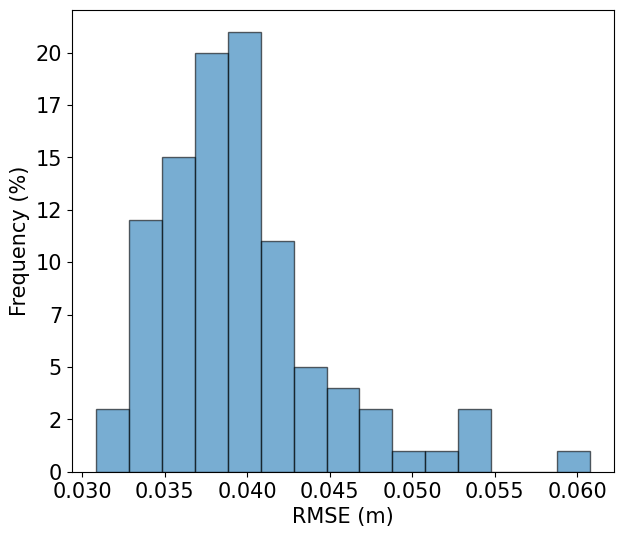

In [15]:
plot_histogram(df['rmse'], 'RMSE (m)')

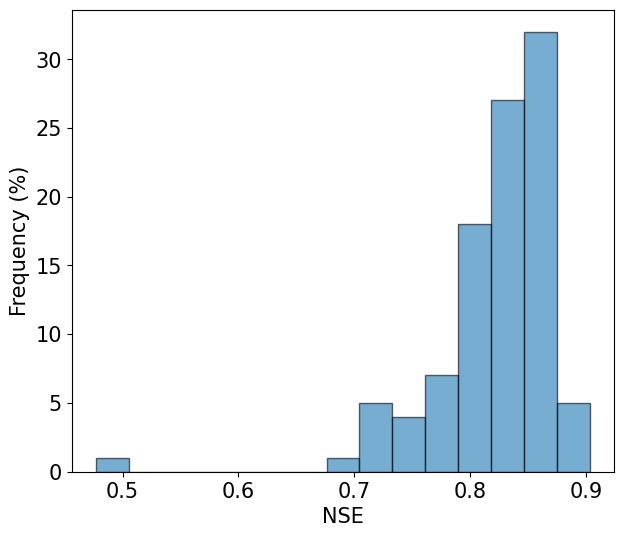

In [16]:
plot_histogram(df['nse'], 'NSE')

In [18]:
df.iloc[df['nse'].idxmax()]

seed    97848.000000
rmse        0.030929
nse         0.902880
Name: 34, dtype: float64

In [19]:
df.iloc[df['rmse'].idxmin()]

seed    31203.000000
rmse        0.030872
nse         0.882143
Name: 60, dtype: float64

In [20]:
# Write the result in a CSV file
df.to_csv(PATH_RESULT + 'result_prev' + LEAD_TIME + 'min.csv')